# DEA EIT sensor-actuator

*Research on the integration of dielectric elastomer actuators (DEAs) and electrical impedance tomography (EIT) based pressure mapping technology.*

This notebook will give the basic models established in the state-of-the-art and compare them to the data we have gathered. However there is very little information on how to create a model for DEA with unconventionally thick electrodes.

Sections:

1. Basic theoretical strain induced on a VHB 4905 dielectric elastomer given a voltage input of 0 - 10 kV

2. Comparing the theoretical calcs to the measured strain data

3. Fitting to the measured strain data

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import optimize
import pandas as pd
%matplotlib inline

# extract data from DEA experiments
xls = pd.ExcelFile('DEA_kV_strain_data.xlsx')
data = pd.read_excel(xls, 'Data')
uncertainties = pd.read_excel(xls, 'Uncertainties')
v_data = data['Voltage [kV]']
columns = ['CBSR (1mm, Bottom)', 'CBSR (1mm, Top)', 'CBSR (2mm, Bottom)', 'CBSR (2mm, Top)', 'CBSR Spider (2mm, Bottom, Horizontal)', 'CBSR Spider (2mm, Top, Horizontal)',
                'CBSR Spider (2mm, Bottom, Vertical)', 'CBSR Spider (2mm, Top, Vertical)', 'CB + CB, CBSR (0.5mm, Horizontal)', 'CB + CB, CBSR (0.5mm, Vertical)', 'CB + CBSR (0.5mm, Vertical)']
keys_data = data[columns]

## 1. Basic theoretical DEA strain

Implementing a basic radial strain model for a circular sandwich DEA topology.

[    0.      637.488  2549.952  5737.392 10199.808 15937.2  ]
[-0.         -0.00448935 -0.01795741 -0.04040417 -0.07182963 -0.1122338 ]
[0.         0.00225226 0.00910147 0.02083564 0.03797322 0.06133063]


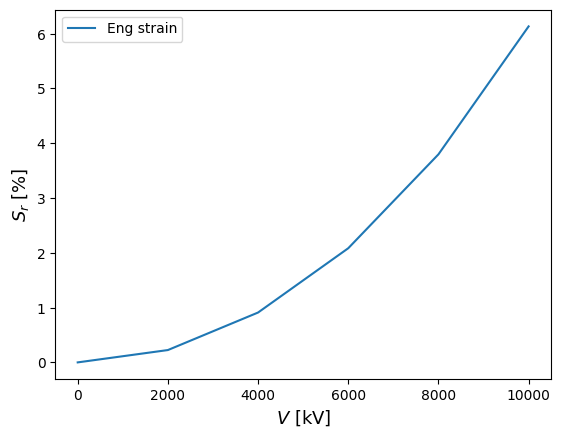

In [33]:
volt_kV = np.linspace(0e3,10e3,6)
z_0_m = 500e-6

perm_0 = 8.854e-12
perm_r = 4.5

K_Pa = 142e3 # See paper from Ellingham et al "Electrical Impedance Tomography Based Pressure Sensor Integration with Dielectric Elastomer Actuators"
stress_es = lambda V, z :  perm_0 * perm_r * (V**2 / z**2) # re-write this as a transfer function with a constant driving voltage??
S_z = lambda stress : -stress / K_Pa
S_r = lambda S_z : np.sqrt(1 / (S_z + 1)) - 1

stress = stress_es(volt_kV, z_0_m)
print(stress)
strain_z = S_z(stress)
print(strain_z)
strain_r = S_r(strain_z)
print(strain_r)

plt.plot(volt_kV, strain_r*1e2, label="Eng strain")
plt.xlabel("$V$ [kV]", fontsize="13")
plt.ylabel("$S_r$ [%]", fontsize="13")
plt.legend()
plt.show()

## 2. Comparing theoretical strain to measured strain

Comparing the basic DEA radial strain model to the actual strain measured

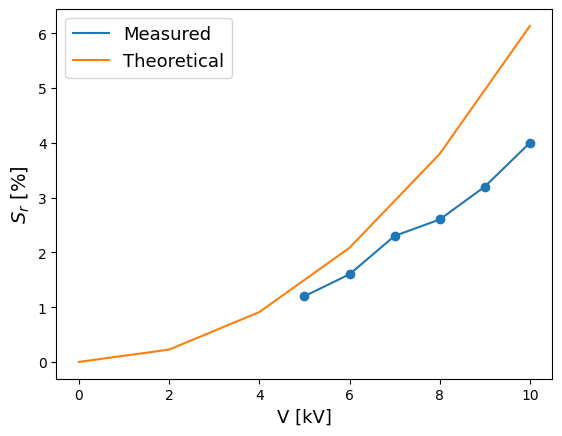

In [34]:
CB_S_r_data = data['CB'] # reference DEA data using CB powder compliant electrodes

plt.plot(v_data, CB_S_r_data, label="Measured")
plt.scatter(v_data, CB_S_r_data)
plt.plot(volt_kV/1e3, strain_r*1e2, label="Theoretical")
    
plt.legend(fontsize="13", loc="upper left")
plt.xlabel("V [kV]", fontsize="13")
plt.ylabel("$S_r$ [%]", fontsize="14")

plt.show()

## 3. Fitting to the measured strain data

Determine the new effective bulk modulus of the 'active volume' (i.e. the compliant electrodes and the sandwiched part of the DE). Assuming dielectric permittivity, $\varepsilon_r$, is constant.

### 3.1 Reference DEA 

Fitted bulk modulus:203.869 kPa
Fitted relative permittivity:3.134


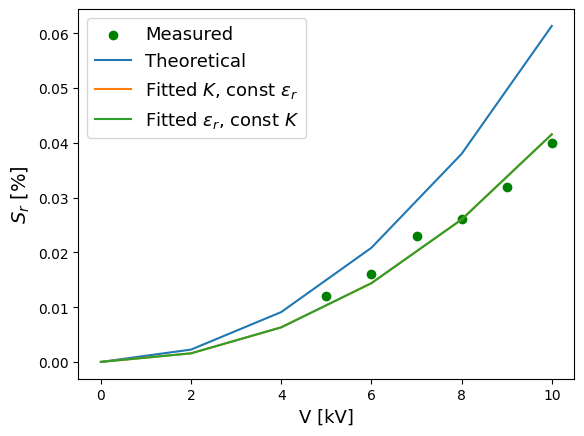

In [116]:
stress_es = lambda V, z :  perm_0 * perm_r * (V**2 / z**2) # re-write this as a transfer function with a constant driving voltage??
S_z = lambda stress : -stress / K_Pa
S_r = lambda S_z : np.sqrt(1 / (S_z + 1)) - 1

def S_r_model(v_data, K, perm_rel):
    return np.sqrt(1 / ((-(perm_0 * perm_rel * (v_data**2 / z_0_m**2)) / K) + 1)) - 1 

def S_r_model_K(v_data, K):
    return np.sqrt(1 / ((-(perm_0 * perm_r * (v_data**2 / z_0_m**2)) / K) + 1)) - 1 

def S_r_model_perm_rel(v_data, perm_rel):
    return np.sqrt(1 / ((-(perm_0 * perm_rel * (v_data**2 / z_0_m**2)) / K_Pa) + 1)) - 1 

# sca1e reference DEA data
v = np.array(v_data*1e3)
s = np.array(CB_S_r_data*1e-2)

init_K = np.ones((1))*K_Pa # use assumed bulk modulus as init guess
K_S_r, K_S_r_cov = optimize.curve_fit(S_r_model_K, v, s, p0=init_K, xtol=1e-6, maxfev=int(1e6), method='lm')
print(f"Fitted bulk modulus:{K_S_r[0]/1e3:.3f} kPa")

inti_perm_r = np.ones((1))*perm_r # use assumed relative electric permittivity as init guess
perm_r_S_r, perm_r_S_r_cov = optimize.curve_fit(S_r_model_perm_rel, v, s, p0=inti_perm_r, xtol=1e-8, maxfev=int(1e9), method='lm')
print(f"Fitted relative permittivity:{perm_r_S_r[0]:.3f}")

plt.scatter(v/1e3, s, marker='o', color='green', label="Measured")
# plt.plot(v, s)
plt.plot(volt_kV/1e3, strain_r, label="Theoretical")
# + fitted K
plt.plot(volt_kV/1e3, S_r_model_K(volt_kV, K_S_r[0]), label="Fitted $K$, const $\\varepsilon_r$")
# + fitted perm_r
plt.plot(volt_kV/1e3, S_r_model_perm_rel(volt_kV, perm_r_S_r[0]), label="Fitted $\\varepsilon_r$, const $K$")

plt.legend(fontsize="13", loc="upper left")
plt.xlabel("V [kV]", fontsize="13")
plt.ylabel("$S_r$ [%]", fontsize="14")

plt.show()

In [118]:
# the difference between the two fits, K and perm_r:
fit_diff = S_r_model_K(volt_kV, K_S_r[0]) - S_r_model_perm_rel(volt_kV, perm_r_S_r[0])
print(fit_diff)

[0.00000000e+00 1.50990331e-13 6.12621065e-13 1.41175960e-12
 2.59681165e-12 4.24482671e-12]


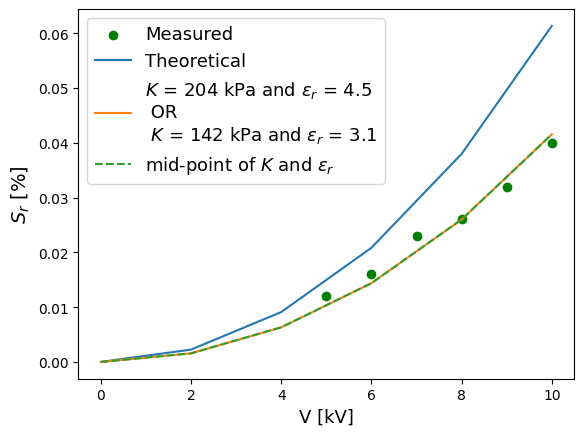

In [124]:
plt.scatter(v/1e3, s, marker='o', color='green', label="Measured")
# plt.plot(v, s)
plt.plot(volt_kV/1e3, strain_r, label="Theoretical")
# + fitted K
plt.plot(volt_kV/1e3, S_r_model_K(volt_kV, K_S_r[0]), label=f"$K$ = {K_S_r[0]/1e3:.0f} kPa and $\\varepsilon_r$ = {perm_r} \n OR \n $K$ = {K_Pa/1e3:.0f} kPa and $\\varepsilon_r$ = {perm_r_S_r[0]:.1f}")
# + fitted perm_r
plt.plot(volt_kV/1e3, S_r_model(volt_kV,(K_S_r[0]+K_Pa)/2, (perm_r_S_r+perm_r)/2), linestyle='--', label="mid-point of $K$ and $\\varepsilon_r$")

plt.legend(fontsize="13", loc="upper left")
plt.xlabel("V [kV]", fontsize="13")
plt.ylabel("$S_r$ [%]", fontsize="14")

plt.show()

# there are a set of solutions for K and perm_r that fit the function K(e_r) = (K_S_r[0] - K_Pa)/(perm_r_S_r - perm_r) * e_r - (perm_r + K_Pa)

### 3.2 Compliant electrodes 0.5, 1, and 2mm thick

44.28571428571429

## Misc

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


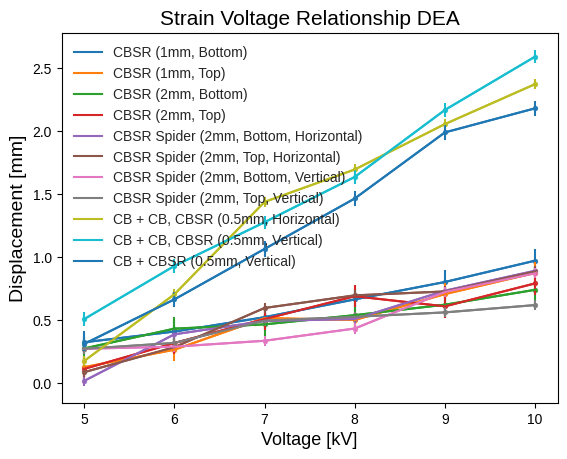

In [5]:
# Code for plotting naive theoretical vs experimental
var = pd.read_excel("DEA_kV_strain_data.xlsx")

x = data['Voltage [kV]']
columns = ['CBSR (1mm, Bottom)', 'CBSR (1mm, Top)', 'CBSR (2mm, Bottom)', 'CBSR (2mm, Top)', 'CBSR Spider (2mm, Bottom, Horizontal)', 'CBSR Spider (2mm, Top, Horizontal)',
                'CBSR Spider (2mm, Bottom, Vertical)', 'CBSR Spider (2mm, Top, Vertical)', 'CB + CB, CBSR (0.5mm, Horizontal)', 'CB + CB, CBSR (0.5mm, Vertical)', 'CB + CBSR (0.5mm, Vertical)']
keys_data = data[columns]

fig, ax = plt.subplots()
tab_colors = list(matplotlib.colors.TABLEAU_COLORS.values())
print(tab_colors)
for index, key in enumerate(keys_data):
    index = index % len(tab_colors)
    y = data[key]
    ax.plot(x, y, color=tab_colors[index])
    ax.errorbar(x, y, xerr=0, yerr=uncertainties[key])

plt.title("Strain Voltage Relationship DEA", fontsize="15")
plt.style.use('seaborn-v0_8')
plt.xlabel("Voltage [kV]", fontsize="13")
plt.ylabel("Displacement [mm]", fontsize="14")
plt.legend(keys_data)

for key in keys_data:
    y = data[key]
    plt.scatter(x, y, marker = "o",s = 12)
    
plt.show()



In [ ]:
#########################################
## REVISED THEORETICAL Z step response ##
#########################################

volt_kV = np.linspace(0,10e3,11)
z_0_um = 500e-6

perm_0 = 8.854e-12
perm_r = 4.2 # http://dengpan.ca/reports/vhb.pdf pre-stretch dependent

Y_Pa = 450e3 # https://www.stockwell.com/data-sheets/vhb-tranfer-tapes-9473pc.pdf pre-stretch dependent??


# re-write this as a transfer function
stress_es = lambda V, z :  perm_0 * perm_r * (V**2 / z**2) 
S_z = lambda stress : -stress / Y_Pa
S_r = lambda S_z : np.sqrt(1 / (S_z + 1)) - 1
# TODO: using kelvin-voight model make an overdamped system!!

# TODO: or using fractional differential modelling do some parameter ID etc... (need to extract time series data from DEA videos...)

er = 100
tol = 1e-3
z_n_arr = []

while er > tol:

In [ ]:
# TODO: fit the stress_es(), S_r(), & S_z() functions with new parameters for 'perm_r' and/or 'K_Pa'

